# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [732]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, accuracy_score, classification_report

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import tqdm

rnd_state = 202007

In [733]:
data = pd.read_csv('/datasets/Churn.csv')

In [734]:
data.shape

(10000, 14)

Размер нашей выборки 10000 событий и 14 признаков

In [735]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Типы данных корректные, ничего менять не нужно

In [736]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [737]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


У 25% клиентов нулевой баланс

25% данных не имеют активности клиента так же нулевой баланс

Удалим лишний столбец RowNumber, CustomerId

Удалим столбец Surname, так как имя не влияет на вероятность ухода из банка.

In [738]:
data = data.drop(['RowNumber','Surname', 'CustomerId'], axis=1)

In [739]:
 data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [740]:
#Посмотрим на количество пропусков в данных
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Пропуски есть только в данных о количестве недвижимости у клиента. Предположительно, что отсутствие данных в данном пункте говорит нам о том, что у клиента нет недвижимости.

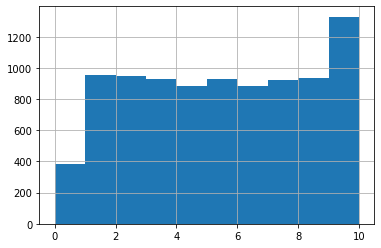

In [741]:
#Посмотрим данные по кол-ву недвижимости подробнее
data['Tenure'].hist()

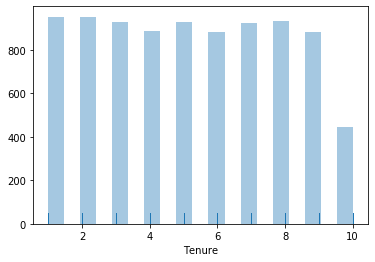

In [742]:
sns.distplot(data.query('Tenure>0').Tenure, kde=False, rug=True);

У каждого значения в признаке Tenure примерно 900-1000 событий, что примерно равно количеству пропусков. 
Скорее всего пропуски - это нули.

In [743]:
data = data.fillna(0)

In [744]:
data['Tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

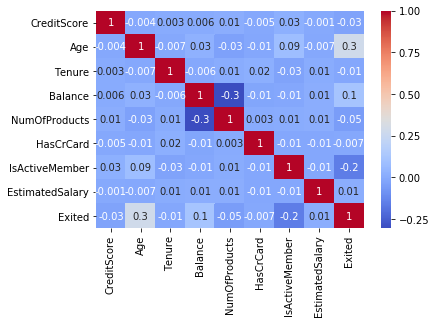

In [745]:
#посомтрим как коррелируют и есть ли явные зависимости между признаками
sns.heatmap(data.corr(),cmap='coolwarm',annot=True, fmt='.1g')

In [746]:
#функция для подсчета коэф.корреляции между столбцами
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.2, .8), xycoords=ax.transAxes, size = 20)

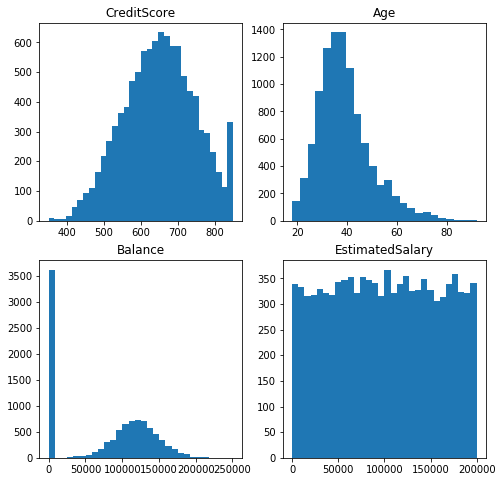

In [747]:
#Построим гистограммы для CreditScore, Age, Balance, EstimatedSalary, чтобы посомтреть их распределения
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].hist(data['CreditScore'], bins=32)
axes[0, 0].set_title("CreditScore")
axes[0, 1].hist(data['Age'], bins=24)
axes[0, 1].set_title("Age")
axes[1, 0].hist(data['Balance'], bins=30)
axes[1, 0].set_title("Balance")
axes[1, 1].hist(data['EstimatedSalary'], bins=30)
axes[1, 1].set_title("EstimatedSalary");

Видим, что кредитный рейтин, возраст имеют распределения, похожие на нормальные. Предполагаемая зарплата имеет равномерное распредление. 
Имеется выброс в 0 у признака Баланс, в остальном он тоже имеет нормальное распределение, никак его обрабатывать не будем

In [748]:
#Посмотрим, жителями каких стран являются клиенты банка
data.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Всего три страны, не так много, чтобы список разросся при дамми-кодировании

In [749]:
#посмотрим на признак Gender
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [750]:
#для категориальных признаков будем использовать OHE

In [751]:
data.loc[:, "Gender"] = (data.Gender == 'Male').astype(int)

In [752]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2.0,125510.82,1,1,1,79084.10,0


In [753]:
OHEncoder = OneHotEncoder()
Geography_OHEncoder = OHEncoder.fit_transform(data[['Geography']]).toarray()
Geography_OHEncoder = pd.DataFrame(Geography_OHEncoder, columns=OHEncoder.categories_[0])

In [754]:
Geography_OHEncoder.head()

,France,Germany,Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [755]:
#OrdinalEnc = OrdinalEncoder()
#geo_OrdinalEnc = OrdinalEnc.fit_transform(data[['Geography']])
#geo_OrdinalEnc = pd.DataFrame(geo_OrdinalEnc, columns=['Geography'])
#geo_OrdinalEnc.head()

In [756]:
#data.loc[:, 'Geography'] = geo_OrdinalEnc.loc[:, 'Geography']
#data.head()

In [757]:
data = data.join(Geography_OHEncoder)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,France,0,42,2.0,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,Spain,0,41,1.0,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,France,0,42,8.0,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,France,0,39,1.0,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,Spain,0,43,2.0,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [758]:
data = data.drop(['Geography'], axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [759]:
#data = pd.get_dummies(data, drop_first=True)
#data.head()

Для более адекватного поведения моделей, чтобы они были в одной размерности, произведем нормирование признаков: CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary

In [760]:
normalized_ax = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = MinMaxScaler()
scaler.fit(data[normalized_ax])
data.loc[:, normalized_ax] = scaler.transform(data[normalized_ax])

In [761]:
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,0.538,0,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1.0,0.0,0.0
1,0.516,0,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0.0,0.0,1.0
2,0.304,0,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1.0,0.0,0.0
3,0.698,0,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1.0,0.0,0.0
4,1.000,0,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0.0,0.0,1.0


### Выводы:

Изучили данные, провели предобработку:

-Заполнили 0 признак наличия недвижимости у клиента

-Удалили столбцы, которые не будут полезны при обучении модели

-Провели дамми-кодирование двух категориальных признаков

-Провели нормирование признаков в интервале от 0 до 1
    

# 2. Исследование задачи

In [762]:
#Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

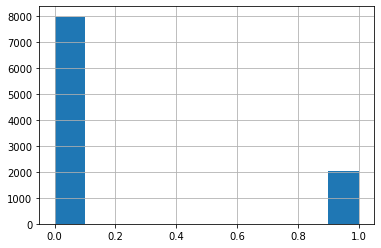

In [763]:
data.Exited.hist()

Мы видим, что у нас дисбаланс классов 80/20

In [764]:
#Обучим модели классификации на не сбалансированном датасете и потом сравним предсказание лчшей модели со случайной моделью
#Для этого подготовим наши данные, разобъем всю выборку на три части: обучающую, валидационную и тестовую.
X = data.drop('Exited', axis=1)
y = data['Exited']

In [765]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=rnd_state, test_size=0.2, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state=rnd_state, test_size=0.5, stratify=y_valid)

In [766]:
#проконтролируем размеры выборок:
X_train.shape, X_valid.shape

((8000, 12), (1000, 12))

In [767]:
X_valid.shape, X_test.shape

((1000, 12), (1000, 12))

In [768]:
#будем собирать данные в сводную таблицу
res=[]

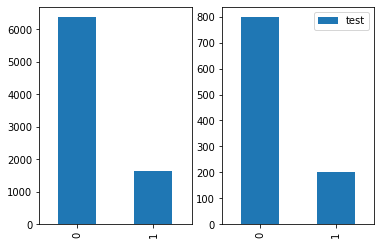

In [769]:
#дисбаланс целевого класса
f, (ax1, ax2) = plt.subplots(1, 2)
y_train.value_counts().plot(kind='bar', ax=ax1, label='train')
y_test.value_counts().plot(kind='bar', ax=ax2, label='test')
plt.legend()

## Выбор модели

Будем рассматривать Алгоритм k-ближайшего соседа, Дерево решений, Случайный лес и Логистическую регрессию.

Для каждого алгоритма подберем лучшие гиперпарамерты поиском по сетке по метрике f1.

### Алгоритм k-ближайшего соседа

In [770]:
param_grid={'n_neighbors': [neighbors for neighbors in range(2, 10, 1)]}
GS = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring='f1')
GS.fit(X_train, y_train)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 3}

In [771]:
model_kn_estimator = KNeighborsClassifier(n_neighbors=3)
model_kn_estimator.fit(X_train, y_train)
predict = model_kn_estimator.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_kn_estimator.predict_proba(X_valid)[:, 1])

print(f"KNeighborsClassifier{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res.append(['model_kn_estimator', GS.best_params_, f1, roc_auc])

KNeighborsClassifier{'n_neighbors': 3}	F1-мера на валидации: 0.43274853801169594	ROC AUC: 0.712896590797123


Максимальное значение F1-меры = 0.43274853801169594 имеем при количестве соседей равным 3, при этом ROC AUC = 0.712896590797123

### Дерево решений / Decision Tree

Глубину для деревьев будем искать в диапазоне от 1 до 21 с шагом 2.

In [772]:
param_grid={'max_depth': [depth for depth in range(1, 21, 2)]}
GS = GridSearchCV(DecisionTreeClassifier(random_state=rnd_state), param_grid=param_grid, scoring='f1')
GS.fit(X_train, y_train)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'max_depth': 5}

In [773]:
model_tree_estimator = DecisionTreeClassifier(max_depth=5, random_state=rnd_state)
model_tree_estimator.fit(X_train, y_train)
predict = model_tree_estimator.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_tree_estimator.predict_proba(X_valid)[:, 1])

print(f"DecisionTreeClassifier{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res.append(['model_tree_estimator', GS.best_params_, f1, roc_auc])

DecisionTreeClassifier{'max_depth': 5}	F1-мера на валидации: 0.5419354838709677	ROC AUC: 0.8452772440634545


Дерево решений имеет максимальное значение F1-меры = 0.5419354838709677, когда гиперпараметр глубины = 7, при этом ROC AUC = 0.8452772440634545

### Случайный лес / Random Forest

Количество деревьев для нашего случайного леса будем искать в диапазоне от 10 до 100 с шагом 10. Глубину для деревьев будем искать в диапазоне от 1 до 21 с шагом 2.

In [774]:
param_grid={'max_depth': [depth for depth in range(1, 21, 2)], 'n_estimators': [estim for estim in range(10, 101, 10)]}
GS = GridSearchCV(RandomForestClassifier(random_state=rnd_state), param_grid=param_grid)
GS.fit(X_train, y_train)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 9, 'n_estimators': 60}

In [775]:
model_rf_estimator = RandomForestClassifier(n_estimators=60, max_depth=9, random_state=rnd_state)
model_rf_estimator.fit(X_train, y_train)
predict = model_rf_estimator.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_rf_estimator.predict_proba(X_valid)[:, 1])
    
print(f"RandomForestClassifier{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res.append(['model_rf_estimator', GS.best_params_, f1, roc_auc])

RandomForestClassifier{'max_depth': 9, 'n_estimators': 60}	F1-мера на валидации: 0.5442622950819672	ROC AUC: 0.8759360528130851


Случайный лес решений имеет максимальное значение F1-меры = 0.5442622950819672, когда гиперпараметр глубины = 11, а кол-во деревьев = 60, при этом ROC AUC = 0.8759360528130851

### Логистическая регрессия / Logistic Regression

Для Логистической регрессии будем подбирать параметр регуляризации С и штраф l1 и l2.

In [776]:
param_grid={'penalty': ['l1','l2'], 'C': np.logspace(-2, 1, 10)}
GS = GridSearchCV(LogisticRegression(random_state=rnd_state), param_grid=param_grid)
GS.fit(X_train, y_train)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

{'C': 0.1, 'penalty': 'l1'}

In [777]:
model_lr_estimator = LogisticRegression(C = 0.1, penalty = 'l1', random_state=rnd_state)
model_lr_estimator.fit(X_train, y_train)
predict = model_lr_estimator.predict(X_valid)
f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_lr_estimator.predict_proba(X_valid)[:, 1])
    
print(f"LogisticRegression{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res.append(['model_lr_estimator', GS.best_params_, f1, roc_auc])

LogisticRegression{'C': 0.1, 'penalty': 'l1'}	F1-мера на валидации: 0.3161764705882353	ROC AUC: 0.7914572864321608


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Логистическая регрессия имеет максимальное значение F1-меры = 0.3161764705882353, когда параметр регуляризации С = 0.1, а штраф = l1, при этом ROC AUC = 0.7914572864321608

In [778]:
#посмотрим на сведенные данные
res = pd.DataFrame(data=res, columns=['model', 'params', 'f1', 'roc_auc'])
res

,model,params,f1,roc_auc
0,model_kn_estimator,{'n_neighbors': 3},0.432749,0.712897
1,model_tree_estimator,{'max_depth': 5},0.541935,0.845277
2,model_rf_estimator,"{'max_depth': 9, 'n_estimators': 60}",0.544262,0.875936
3,model_lr_estimator,"{'C': 0.1, 'penalty': 'l1'}",0.316176,0.791457


случайный лес показывает, немного лучшие результаты, посмотрим его

In [779]:
#Проверим нашу модель на адекватность, сгенерируем псевдослучайную последовательность 0 и 1, равную размером с тестовой выборкой и сравним метрики
y_random = [np.random.randint(0, 2) for i in range(len(y_test))]

In [780]:
#Обучим нашу модель с полученными гиперпареметрами
model_rf_estimator.fit(X_train, y_train)
predicted = model_rf_estimator.predict(X_test)
probabilities_valid = model_rf_estimator.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

In [781]:
#посмотрим меры на выборках
print("F1 на тестовой выборке: {:.3f}".format(f1_score(y_test, predict)))
print("F1 на случайной выборке: {:.3f}".format(f1_score(y_random, predict)))
print("ROC AUC на тестовой выборке: {:.3f}".format(roc_auc_score(y_test, probabilities_one_valid)))
print("ROC AUC на случайной выборке: {:.3f}".format(roc_auc_score(y_random, probabilities_one_valid)))

F1 на тестовой выборке: 0.081
F1 на случайной выборке: 0.115
ROC AUC на тестовой выборке: 0.869
ROC AUC на случайной выборке: 0.501


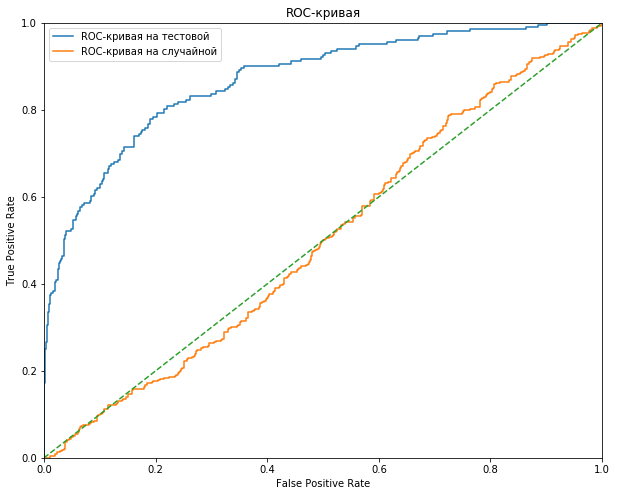

In [782]:
#Построим ROC-кривую
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
fpr_random, tpr_random, thresholds = roc_curve(y_random, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot(fpr_random, tpr_random, label='ROC-кривая на случайной')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы

Построение модели класификации методом случайного леса на несбланасированом наборе данных показало, что наша модель предсказывает лучше чем случайная модель, но недостаточно хорошо, чтобы данную модель можно было использовать. 

Для улучшения показателей мы можем сбалансировать классы.


# 3. Борьба с дисбалансом

Пропорция дисбалана классов равна 80/20.

Поробуем бороться с дисбалансом используя несколько подходов:

1) upsampling

2) downsampling

3) upsampling и downsampling:

При сокращении 0 класс, мы слишком сократим размер набора данных.
При увеличении 1 класс мы слишком "раздуем" его.
Поэтому попробуем сократить 0 класс и увеличить 1 класс

In [783]:
#функция по уменьшению размера выборки, для сокращения класса 0
def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=rnd_state)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=rnd_state)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=rnd_state)
    
    return X_downsampled, y_downsampled

In [784]:
#функция по увеличению размера выборки, для увеличения класса 1
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=rnd_state)
    
    return X_upsampled, y_upsampled

((8000, 12), (8000,))

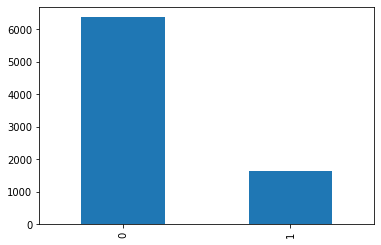

In [785]:
y_train.value_counts().plot(kind='bar')
X_train.shape, y_train.shape

In [786]:
y_train.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

## 1) upsampling

((12890, 12), (12890,))

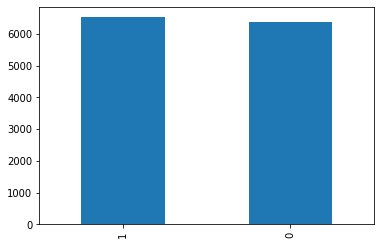

In [787]:
X_train_up, y_train_up = upsample(X_train, y_train, 4)
y_train_up.value_counts().plot(kind='bar')
X_train_up.shape, y_train_up.shape

In [788]:
#проверим сбалансированность данных по классам
y_train_up.value_counts()

1    6520
0    6370
Name: Exited, dtype: int64

## 2) downsampling

((3261, 12), (3261,))

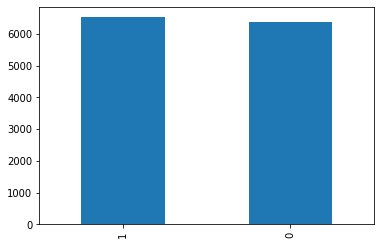

In [789]:
X_train_down, y_train_down = downsample(X_train, y_train, 0.256)
y_train_up.value_counts().plot(kind='bar')
X_train_down.shape, y_train_down.shape

In [790]:
y_train_down.value_counts()

0    1631
1    1630
Name: Exited, dtype: int64

## 3) upsampling и downsampling

In [791]:
X_train_up_down, y_train_up_down = upsample(X_train, y_train, 3)
X_train_up_down, y_train_up_down = downsample(X_train_up_down, y_train_up_down, 0.767)

((9776, 12), (9776,))

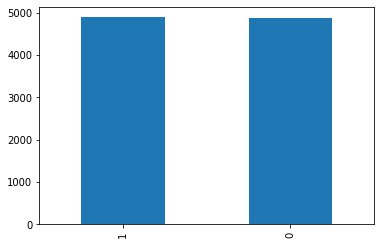

In [792]:
y_train_up_down.value_counts().plot(kind='bar')
X_train_up_down.shape, y_train_up_down.shape

In [793]:
y_train_up_down.value_counts()

1    4890
0    4886
Name: Exited, dtype: int64

In [794]:
#Проверим модель случайного леса на данных с upsample, downsample, upsample и downsample
rf = RandomForestClassifier(n_estimators=60, max_depth=11, random_state=rnd_state, class_weight='balanced' )
cv = StratifiedKFold(n_splits=5, random_state=rnd_state)

In [795]:
results = {'roc_auc_mean': [], 'f1_mean': []}
index=['source', 'up', 'down', 'up_down']
XX = [X_train, X_train_up, X_train_down, X_train_up_down]
yy = [y_train, y_train_up, y_train_down, y_train_up_down]

for x, y, i in zip(XX, yy, index):
    for m in ['roc_auc', 'f1']:
        cv_score = cross_val_score(rf, x, y, cv=cv, scoring=m)
        results[m + '_mean'].append(cv_score.mean())

pd.DataFrame(data=results, index=index)

,roc_auc_mean,f1_mean
source,0.853487,0.608899
up,0.954924,0.889033
down,0.850415,0.766520
up_down,0.943891,0.869934


Самый большой прирост качества на данных с upsampling

In [823]:
res_up=[]

### Алгоритм k-ближайшего соседа

In [824]:
param_grid={'n_neighbors': [neighbors for neighbors in range(2, 10, 1)]}
GS = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring='f1')
GS.fit(X_train_up, y_train_up)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 2}

In [825]:
model_kn_estimator_up = KNeighborsClassifier(n_neighbors=2)
model_kn_estimator_up.fit(X_train_up, y_train_up)
predict = model_kn_estimator_up.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_kn_estimator_up.predict_proba(X_valid)[:, 1])

print(f"KNeighborsClassifier_UP{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res_up.append(['model_kn_estimator_UP', GS.best_params_, f1, roc_auc])	

KNeighborsClassifier_UP{'n_neighbors': 2}	F1-мера на валидации: 0.4289276807980049	ROC AUC: 0.6846548921075968


### Дерево решений / Decision Tree

In [826]:
param_grid={'max_depth': [depth for depth in range(1, 21, 2)]}
GS = GridSearchCV(DecisionTreeClassifier(random_state=rnd_state), param_grid=param_grid, scoring='f1')
GS.fit(X_train_up, y_train_up)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 19}

In [827]:
model_tree_estimator_up = DecisionTreeClassifier(max_depth=19, random_state=rnd_state)
model_tree_estimator_up.fit(X_train_up, y_train_up)
predict = model_tree_estimator_up.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_tree_estimator_up.predict_proba(X_valid)[:, 1])

print(f"DecisionTreeClassifier_UP{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res_up.append(['model_tree_estimator_UP', GS.best_params_, f1, roc_auc])

DecisionTreeClassifier_UP{'max_depth': 19}	F1-мера на валидации: 0.4988344988344988	ROC AUC: 0.6944249433441718


### Случайный лес / Random Forest

In [828]:
param_grid={'max_depth': [depth for depth in range(1, 21, 2)], 'n_estimators': [estim for estim in range(10, 101, 10)]}
GS = GridSearchCV(RandomForestClassifier(random_state=rnd_state), param_grid=param_grid)
GS.fit(X_train_up, y_train_up)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 19, 'n_estimators': 100}

In [829]:
model_rf_estimator_up = RandomForestClassifier(n_estimators=100, max_depth=19, random_state=rnd_state)
model_rf_estimator_up.fit(X_train_up, y_train_up)
predict = model_rf_estimator_up.predict(X_valid)

f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_rf_estimator_up.predict_proba(X_valid)[:, 1])
    
print(f"RandomForestClassifier_UP{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res_up.append(['model_rf_estimator_UP', GS.best_params_, f1, roc_auc])

RandomForestClassifier_UP{'max_depth': 19, 'n_estimators': 100}	F1-мера на валидации: 0.6091644204851752	ROC AUC: 0.8648019509311264


### Логистическая регрессия / Logistic Regression

In [830]:
param_grid={'penalty': ['l1','l2'], 'C': np.logspace(-2, 1, 10)}
GS = GridSearchCV(LogisticRegression(random_state=rnd_state), param_grid=param_grid)
GS.fit(X_train_up, y_train_up)
GS.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

{'C': 1.0, 'penalty': 'l1'}

In [831]:
model_lr_estimator_up = LogisticRegression(C = 1.0, penalty = 'l1', random_state=rnd_state)
model_lr_estimator_up.fit(X_train_up, y_train_up)
predict = model_lr_estimator_up.predict(X_valid)
f1 = f1_score(y_valid, predict)
roc_auc = roc_auc_score(y_valid, model_lr_estimator_up.predict_proba(X_valid)[:, 1])
    
print(f"LogisticRegression_UP{GS.best_params_}\tF1-мера на валидации: {f1}\
\tROC AUC: {roc_auc}")

res_up.append(['model_lr_estimator_UP', GS.best_params_, f1, roc_auc])


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression_UP{'C': 1.0, 'penalty': 'l1'}	F1-мера на валидации: 0.5328467153284672	ROC AUC: 0.7929167898315104


In [832]:
res_up = pd.DataFrame(data=res_up, columns=['model', 'params', 'f1', 'roc_auc'])
res_up

,model,params,f1,roc_auc
0,model_kn_estimator_UP,{'n_neighbors': 2},0.428928,0.684655
1,model_tree_estimator_UP,{'max_depth': 19},0.498834,0.694425
2,model_rf_estimator_UP,"{'max_depth': 19, 'n_estimators': 100}",0.609164,0.864802
3,model_lr_estimator_UP,"{'C': 1.0, 'penalty': 'l1'}",0.532847,0.792917


# 4. Тестирование модели

Протестируем выбранный самый оптимальный классификатор на тестовом наборе данных 

Обучим модель еще раз, с гиперпараметрами, которые мы получили, как наиболее удачные


In [833]:
model = RandomForestClassifier(n_estimators=100, max_depth=19, random_state=rnd_state, class_weight='balanced' )
model.fit(X_train_up, y_train_up)
predict_valid = model.predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    
print(f'F1-мера на валидации: {round(f1_score(y_valid, predict_valid), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.598    	ROC AUC: 0.869


In [834]:
#протестируем модель на тестовых данных
predict_test = model.predict(X_test)
probabilities_one_valid = model.predict_proba(X_test)[:, 1]
    
print(f'F1-мера на тесте: {round(f1_score(y_test, predict_test), 3)}\
    \tROC AUC: {round(roc_auc_score(y_test, probabilities_one_valid), 3)}')

F1-мера на тесте: 0.623    	ROC AUC: 0.859


На тестовой выборке наша модель показывает хорошие результаты, соизмеримые с результатами на валидационной выборке

In [835]:
#Проверим баланс предсказываемых классов
pd.Series(predict_test).value_counts(normalize=True)

0    0.821
1    0.179
dtype: float64

Баланс классов соблюден с небольшим перекосом в сторону предсказания вероятности ухода клиента. 
Будем считать нашу модель адекватной, с отличной предсказательной способностью.

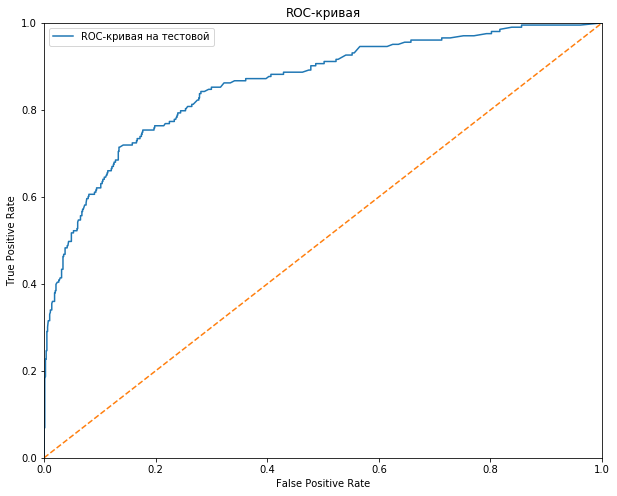

In [836]:
#Исследуем ROC-кривую нашей модели
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Наша модель хорошо предсказывает TPR при практически нулевом FPR. 
Скорее всего модель перобучилась на наборе данных, так как в нем присутствовало большое количество повторений событий. 
Получили существенный прирост качества на данных с применением upsampling и downsampling
Вероятно в тестовый набор попали события, часть данных в результате перемешивания были и в обучающей и в валидационнй выборке на кроссвалидации

Мы реализовали модель классификации, для сохранения клиентов банка
На тестовой выборке достигнуто необходимое значение метрики f1 с вероятностью точного предсказания данной модели около 60%, что можно считать довольно хорошим показателем.
roc_auc не сильно отличается от значение на валидации на исходной и с применением upsampling и downsampling